## Basic benchmarks on NNGPR
This notebooks runs NNGPR and the standard Gaussian Process Regressor on a bucnh of toy datasets.
Requires `matplotlib` and `ucimlrepo` packages, next to `scikit-learn` of course. `cupy` and `gpytorch` are needed to run CUNNGPR and VNNGPR, respectively.

In [1]:
import os
import time
import math
import warnings

import joblib
from joblib.parallel import parallel_config
import scipy
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn import metrics
from sklearn import datasets as sk_datasets
from sklearn.exceptions import ConvergenceWarning
from matplotlib import pyplot as plt
from ucimlrepo import fetch_ucirepo

from nngpr import NNGPR

use_cunngpr = True  # Set to False if you don't have cupy
use_vnngpr = False  # Set to True if you want to test Gpytorch VNNGP. I set to False because I get out of memory error on my 12GB GPU.

In [2]:
# Try importing cuda optional libraries
if use_cunngpr:
    try:
        from nngpr.cunngpr import CUNNGPR
    except ImportError:
        print("Unable to import cunngpr, probably 'cupy' dependency is not installed, will not benchmark CUNNGPR")
        use_cunngpr = False

if use_vnngpr:
    try:
        import gpytorch
        import torch
        use_vnngpr = True
    except ImportError:
        print("Unable to import gpytorch, will not benchmark VNNGPR")
        use_vnngpr = False

##### Config

In [3]:
# Choose datas ets to run. Can choose among 'Elevators', '3droad', 'California_housing', 'Gas_turbine_nox'
dset_names = ['Elevators', '3droad', 'California_housing', 'Gas_turbine_nox']
dset_dims = [1000, 3000, 10000, 20000, 50000, 100000, 200000]  # Each dataset is truncated to the size specified here. If the size is
# larger than the dataset size, the run will be skipped
models_to_run = ['GP', 'NNGPR-32', 'NNGPR-64']
if use_cunngpr:
    models_to_run += ['CUNNGPR-32', 'CUNNGPR-64', 'CUNNGPR-128']
if use_vnngpr:
    models_to_run += ['VNNGPR-32', 'VNNGPR-64', 'VNNGPR-128']
max_gp_dset_size = 20000  # Datasets of bigger size will not be fitted by the plain Gaussian Process Regressor. Change based on you RAM
max_noncuda_gp_dset_size = 20000  # Datasets of bigger size will not be fitted by non cuda-based models. 
# size. 20000 was fine on 64GB ram.

test_perc = 0.2  # Define test set fraction
n_restarts_optimizer = 3  # Scikitlearn parameter
results = {}

##### Datasets

In [4]:
def get_dset(dset_name):
    if dset_name == 'Elevators':  # Taken from GPytorch examples
        data = scipy.io.loadmat('datasets/elevators.mat')['data']
        y = data[:, -1]
        X = data[:, :-1]
        del data
        
    elif dset_name == '3droad':  # Taken from GPytorch examples
        data = scipy.io.loadmat('datasets/3droad.mat')['data']
        X = data[:, :-1]
        y = data[:, -1]
        del data

    elif dset_name == 'California_housing':
        data = sk_datasets.fetch_california_housing()
        X = data['data']
        y = data['target']

    elif dset_name == 'Gas_turbine_nox':
        data = fetch_ucirepo(id=551)
        X = data.data.features.values
        y = X[:, -1]
        X = X[:, :-1]
        
    else:
        raise NotImplementedError(dset_name)
        
    X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)
    assert(np.all(np.isfinite(X)))
    y = (y - np.mean(y)) / np.std(y)
    assert(np.all(np.isfinite(y)))
    
    train_n = int(math.floor((1-test_perc) * len(X)))
    x_train = X[:train_n, :]
    y_train = y[:train_n]
    
    x_test = X[train_n:, :]
    y_test = y[train_n:]

    return x_train, y_train, x_test, y_test


#### Define fitting functions

In [5]:
def get_kern(x):
    return kernels.ConstantKernel(1e-1) * kernels.RBF(1e-1) + kernels.WhiteKernel(1e-1)

def fit_gp_mdl(x, y, x_test):
    mdl = GaussianProcessRegressor(kernel=get_kern(x), alpha=1e-8, n_restarts_optimizer=n_restarts_optimizer)
    mdl.fit(x, y)
    return mdl.predict(x_test)

def fit_nngpr_mdl(x, y, x_test, num_nn=32):
    # To make a fair comparison, use the same number of jobs as the one used by the openblas, MKL, or similars. Indeed, standard GP performs operations on large matrices
    # which are done in parallel by Blas libraries, while NNGPR works with small matrices which are typically executed sequentially
    n_jobs = int(os.getenv('MKL_NUM_THREADS', os.getenv('OPENBLAS_NUM_THREADS', os.getenv('BLIS_NUM_THREADS', joblib.effective_n_jobs()))))
    mdl = NNGPR(kernel=get_kern(x), alpha=1e-8, n_restarts_optimizer=n_restarts_optimizer, num_nn=num_nn, n_jobs=n_jobs)
    with parallel_config(backend="loky", inner_max_num_threads=1):
        mdl.fit(x, y)
        return mdl.predict(x_test)
    
fit_functions = {
    'GP': fit_gp_mdl,
    'NNGPR': fit_nngpr_mdl,
}

In [6]:
if use_cunngpr:
    def fit_cunngpr_mdl(x, y, x_test, num_nn=64):
        mdl = CUNNGPR(kernel=get_kern(x), alpha=1e-8, n_restarts_optimizer=n_restarts_optimizer, num_nn=num_nn, 
                      allow_downcast_f32='only-nn') # I'm using an RTX4070S with crippled f64 performance, so let's switch to float32 at least for nn search
        mdl.fit(x, y)
        return mdl.predict(x_test)

    fit_functions['CUNNGPR'] = fit_cunngpr_mdl

In [7]:
if use_vnngpr:

    class VNNGPModel(gpytorch.models.ApproximateGP):
    
        def __init__(self, inducing_points, likelihood, k=256, training_batch_size=256):
    
            m, d = inducing_points.shape
            self.m = m
            self.k = k
    
            variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(m)   
            variational_strategy = gpytorch.variational.nearest_neighbor_variational_strategy.NNVariationalStrategy(
                self, inducing_points, variational_distribution, k=k,
                training_batch_size=training_batch_size)
            
            super(VNNGPModel, self).__init__(variational_strategy)
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
            self.likelihood = likelihood
    
        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
        def __call__(self, x, prior=False, **kwargs):
            if x is not None:
                if x.dim() == 1:
                    x = x.unsqueeze(-1)
            return self.variational_strategy(x=x, prior=False, **kwargs)
        
    def fit_vnngp_mdl(
            x, y, x_test, num_nn=32, do_print=False, n_restarts_optimizer=n_restarts_optimizer, 
            lr=[0.1, 0.02], max_training_iter=20, max_non_decrease_iter=250, use_cuda=False):
        """ This function mimics fitting a GPytorch model. Gpytorch models don't have a .fit method, so we have
        to manually perform optimizazion steps until it convereges.
        
        There are multiple choices that can be made, e.g. stepsize, number of iterations, batch size, etc.
        """

        if use_cuda: # I'm using an RTX4070S with crippled f64 performance
            x, y = x.astype('float32'), y.astype('float32')
            
        x = torch.asarray(x, device='cuda' if use_cuda else 'cpu')
        y = torch.asarray(y, device='cuda' if use_cuda else 'cpu')
        x_test = torch.asarray(x_test, device='cuda' if use_cuda else 'cpu')
        
        # Default vars
        if type(lr) not in [list, tuple]:
            lr = (lr,)
        if type(max_training_iter) not in [list, tuple]:
            max_training_iter = (max_training_iter,) * len(lr)
        if type(max_non_decrease_iter) not in [list, tuple]:
            max_non_decrease_iter = (max_non_decrease_iter,) * len(lr)
        assert len(max_training_iter) == len(lr)
        assert len(max_non_decrease_iter) == len(lr)
    
        best_global_loss = np.inf
        best_global_params = None
        np.random.seed(9283745)
    
        for i_restart in range(n_restarts_optimizer + 1):
            
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            model = VNNGPModel(inducing_points=x, likelihood=likelihood, training_batch_size=2048, k=num_nn)
            if use_cuda:
                model = model.to('cuda')
    
            model.train()
            likelihood.train()
    
            # "Loss" for GPs - the marginal log likelihood
            mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))
            best_run_params = None
            best_run_loss = np.inf
    
            if i_restart > 0:
                hl = 2
                params = {
                    'covar_module.outputscale': 10**(np.random.uniform(low=-hl, high=hl)),
                    'covar_module.base_kernel.lengthscale': 10**(np.random.uniform(low=-hl, high=hl)),
                    'likelihood.noise_covar.noise': 10**(np.random.uniform(low=-hl, high=hl)),
                }
                model.initialize(**params)
    
            for i_lr, (this_lr, mti, mndi) in enumerate(zip(lr, max_training_iter, max_non_decrease_iter)):
                
                if i_lr > 0:
                    model.initialize(**{param[0]: param[1] for param in best_run_params})
                non_decrease_iter = 0
    
                # Create the adam optimizer
                optimizer = torch.optim.Adam(model.parameters(), lr=this_lr)  # Includes GaussianLikelihood parameters
                
                for i in range(mti):
    
                    optimizer.zero_grad()
                    # Output from model
                    output = model(x=None)
                    current_training_indices = model.variational_strategy.current_training_indices
                    y_batch = y[...,current_training_indices]
                    # Calc loss and backprop gradients
                    loss = -mll(output, y_batch)
                    loss.backward()
                    this_loss = loss.item()
    
                    if do_print and ((i+1) % 50 == 0):
                        print('Restart %d - LR %.2e (%d/%d), Iter %d/%d - Loss: %.3f' % (
                            i_restart, this_lr, i_lr +1, len(lr), i + 1, mti, this_loss,
                        ))
    
                    if this_loss < best_global_loss:
                        best_global_params = tuple(model.named_parameters())
    
                    if this_loss < best_run_loss:
                        best_run_params = tuple(model.named_parameters())
                        non_decrease_iter = 0
                        best_run_loss = this_loss
                    else:
                        non_decrease_iter += 1
                        if non_decrease_iter >= mndi:
                            break
    
                    optimizer.step()
    
        # Set the best params
        model.initialize(**{param[0]: param[1] for param in best_global_params})
    
        model.eval()
        likelihood.eval()
    
        pred = likelihood(model(x_test))
        return pred.mean.detach().numpy()
    
    fit_functions['VNNGPR'] = fit_vnngp_mdl

#### Run models

In [ ]:
for dset_name in dset_names:
    if dset_name not in results:
        results[dset_name] = {}
    dset_res = results[dset_name]
    x_train, y_train, x_test, y_test = get_dset(dset_name)
    print(dset_name, x_train.shape)
    
    for n in dset_dims:
        if n not in dset_res:
            dset_res[n] = {}
        this_res = dset_res[n]
        
        for name in models_to_run:
            tag = name
            kwargs = {}
            if (n > x_train.shape[0]) or (name in this_res):
                continue
            if (name == 'GP') and (n > max_gp_dset_size):  # Prevent out of memory
                continue
            if (not name.startswith('CUNNGPR') and not name.startswith('VNNGPR')) and (n > max_noncuda_gp_dset_size):  # Prevent long runtime
                continue
            if name.startswith('NNGPR'):
                tag = 'NNGPR'
                kwargs['num_nn'] = int(name.split('-')[1])
            if name.startswith('CUNNGPR'):
                tag = 'CUNNGPR'
                kwargs['num_nn'] = int(name.split('-')[1])
            print(dset_name, name, n)
            t0 = time.time()
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=ConvergenceWarning)
                pred = fit_functions[tag](x_train[:n], y_train[:n], x_test, **kwargs)
            t = (time.time() - t0) / n_restarts_optimizer
            this_res[name] = {
                'time': t,
                'pred': pred,
                'y_test': y_test
            }

#### Plot results
Current results based on Ryzen 9700X and RTX4070S

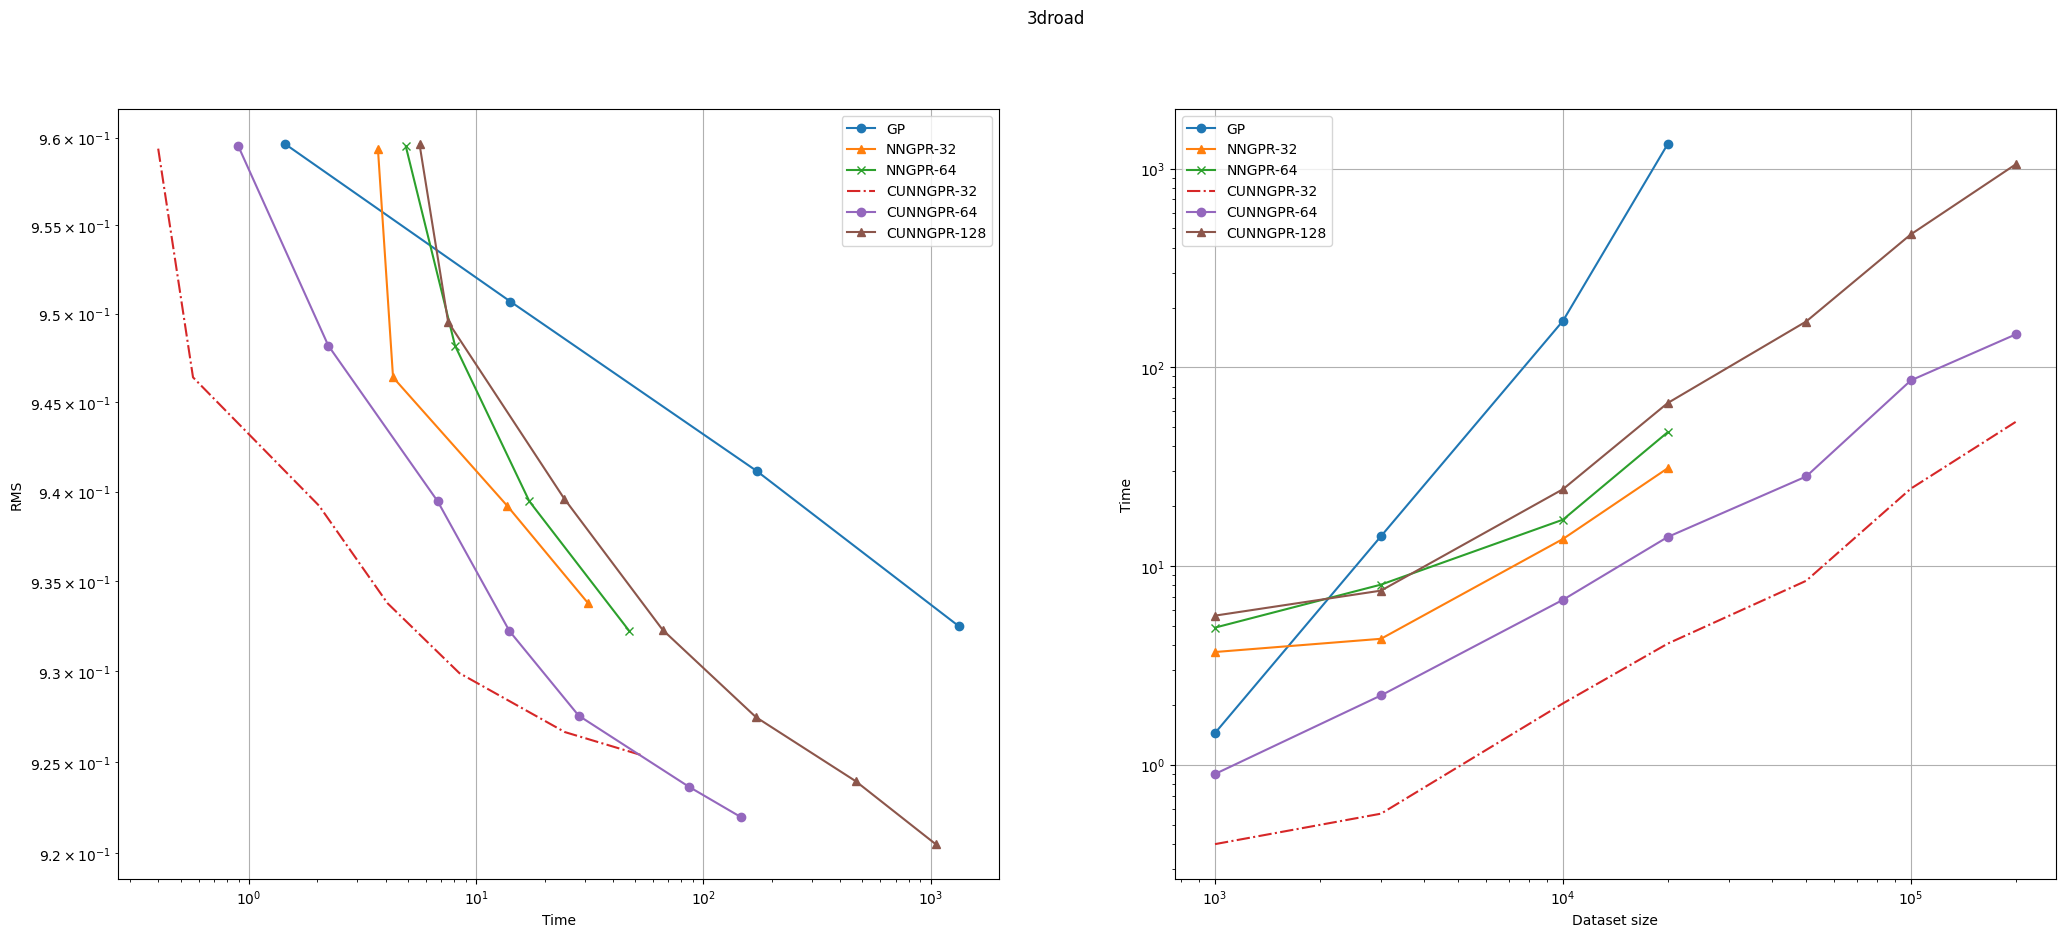

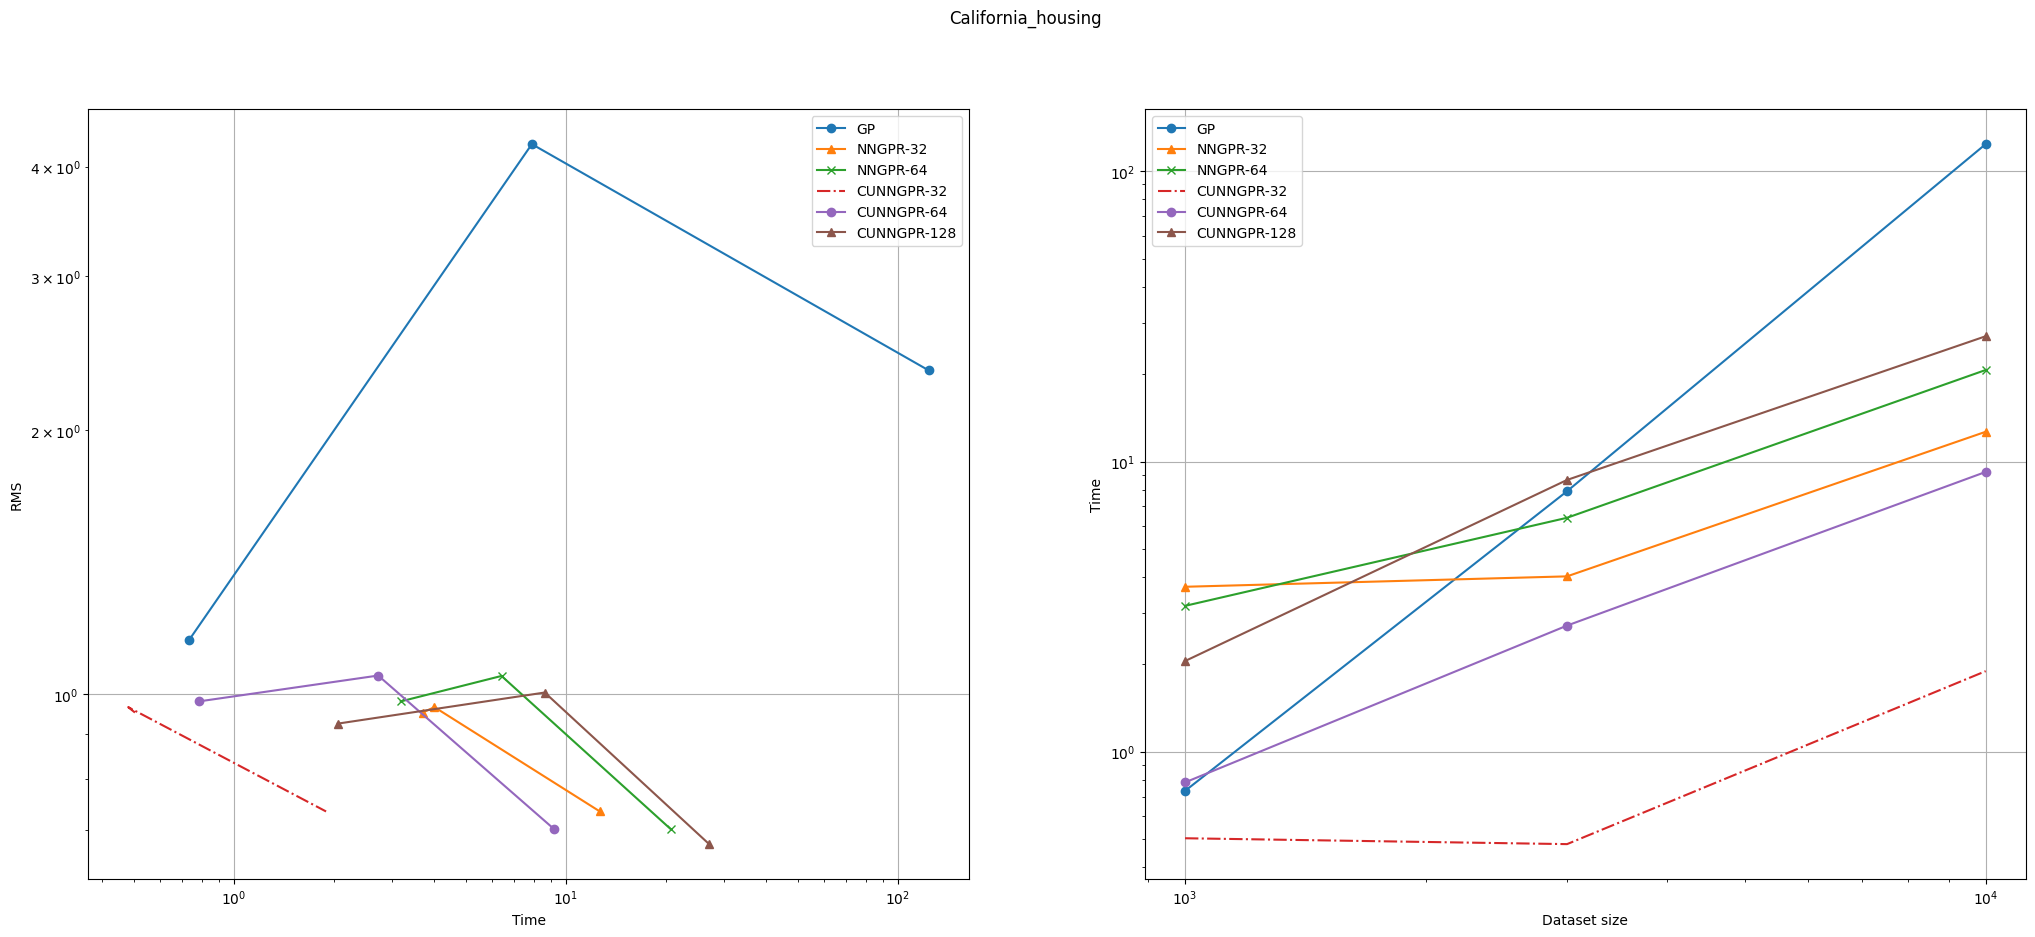

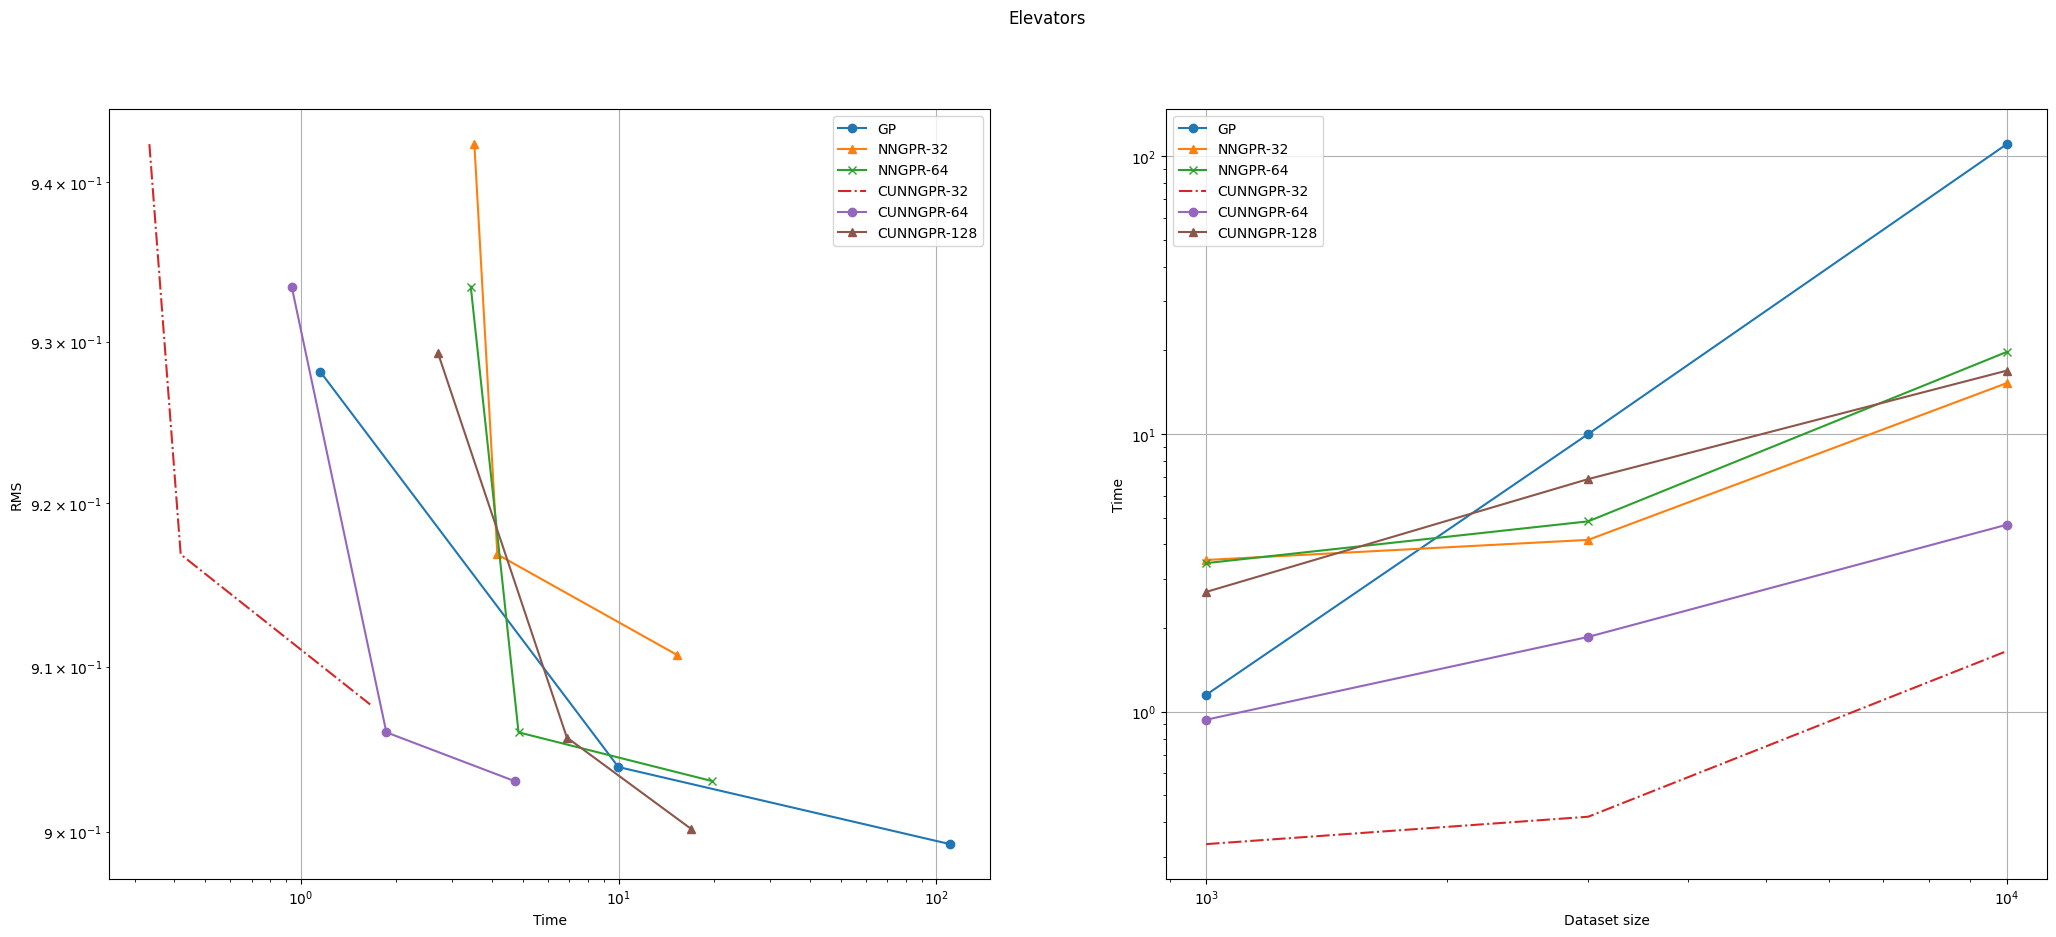

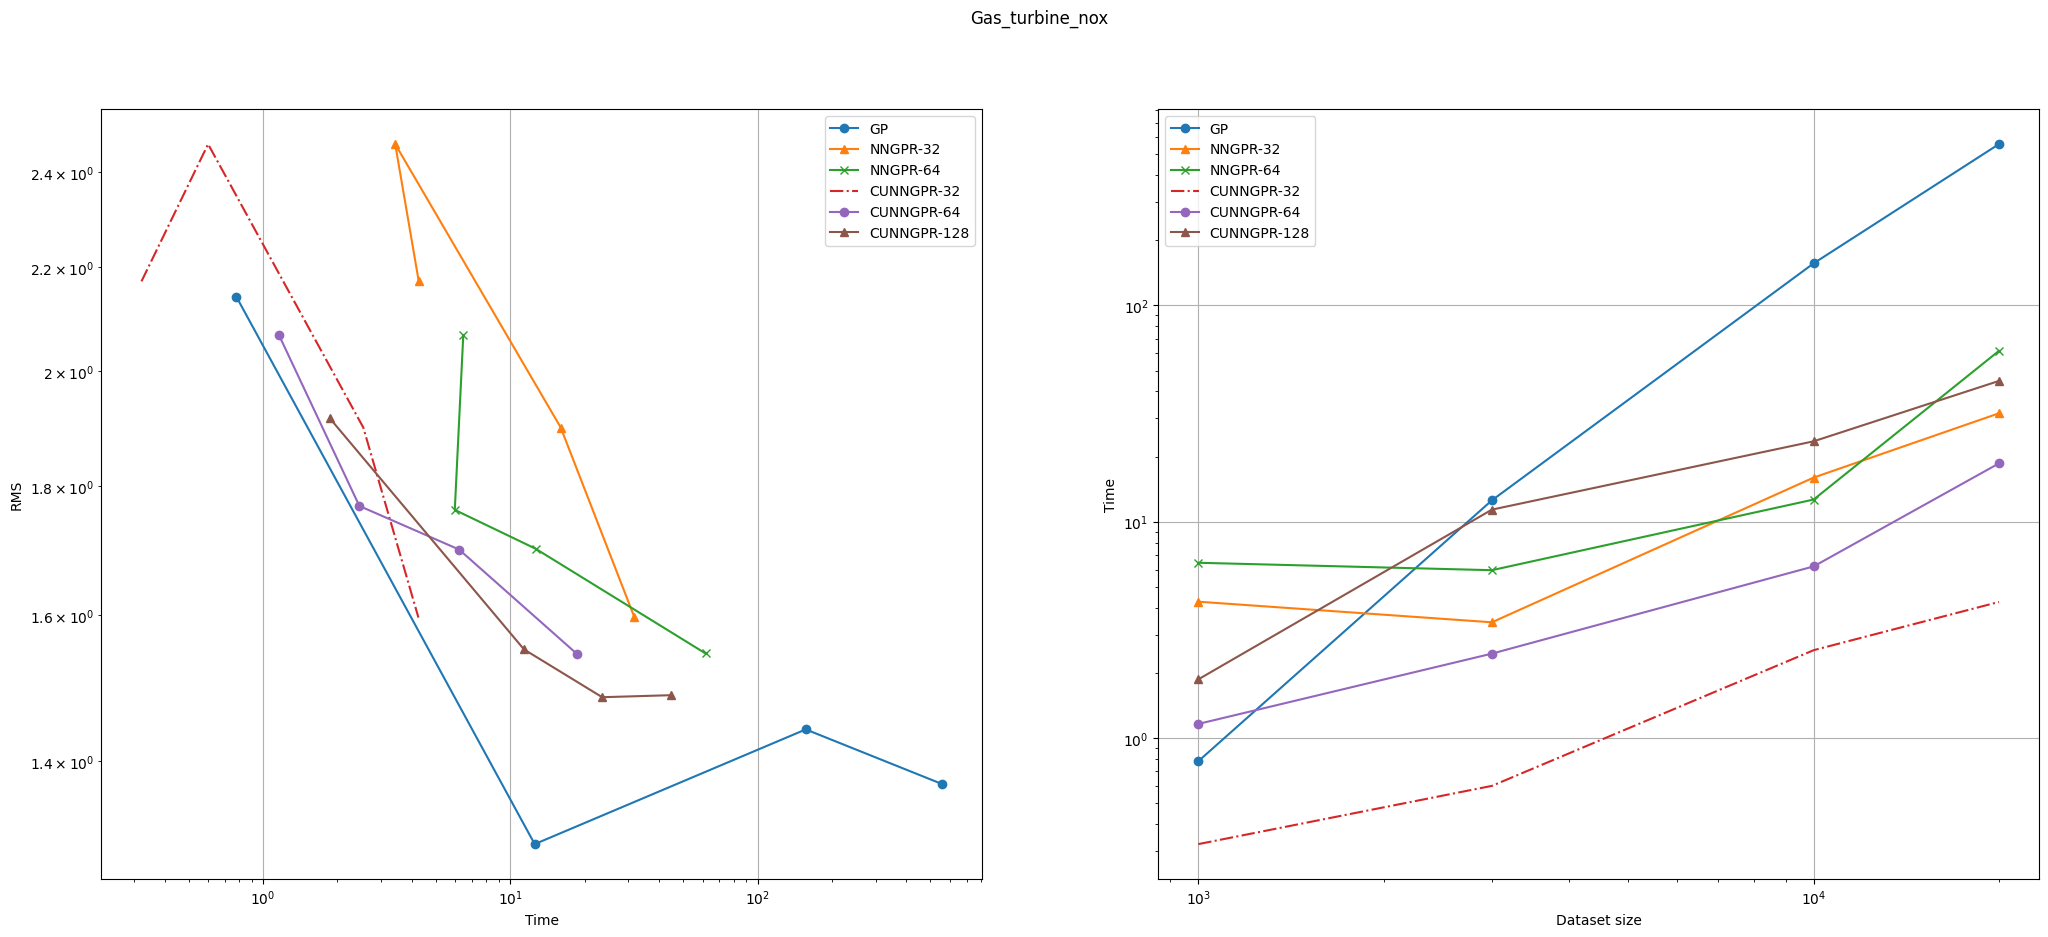

In [6]:
marks = ['o', '^', 'x', '.']

for dset_name in sorted(results):
    dset_results = results[dset_name]
    to_plot = {}
    for n, res in dset_results.items():
        for name, data in res.items():
            if name not in to_plot:
                to_plot[name] = {'time': [], 'metric': [], 'n': []}
            to_plot[name]['time'].append(data['time'])
            to_plot[name]['metric'].append(metrics.root_mean_squared_error(data['y_test'], data['pred']))
            to_plot[name]['n'].append(n)

    for name in list(to_plot.keys()):
        tmp = to_plot[name]
        sorter = np.argsort(tmp['n'])
        to_plot[name] = {'time': np.array(tmp['time'])[sorter], 'metric': np.array(tmp['metric'])[sorter], 'n': np.array(tmp['n'])[sorter]}

    fig, axs = plt.subplots(1,2)
    fig.set_figwidth(25)
    fig.set_figheight(10)
    fig.suptitle(dset_name)

    ax = axs[0]
    ax.grid(True)
    for i, (name, data) in enumerate(to_plot.items()):
        ax.plot(data['time'], data['metric'], '-'+marks[i % len(marks)], label=name)
    ax.set_xlabel('Time')
    ax.set_ylabel('RMS')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

    ax = axs[1]
    ax.grid(True)
    for i, (name, data) in enumerate(to_plot.items()):
        ax.plot(data['n'], data['time'], '-'+marks[i % len(marks)], label=name)
    ax.set_xlabel('Dataset size')
    ax.set_ylabel('Time')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()